In [158]:
import os
import torch
from torchvision import transforms

In [159]:
print(os.getcwd())
currentPath = os.getcwd().split('/')

indexOf = currentPath.index('workspace')
rootPath = '/'.join(currentPath[:indexOf+1])+'/CDCGAN'
os.chdir(rootPath)
root = os.getcwd()

print(root)

/workspace/CDCGAN
/workspace/CDCGAN


In [160]:
from packages.dataHandlers.datasetMannager import datasetMannager

import packages.arquitectures.CDCGAN as GanMannager
import packages.arquitectures.networks as networks

# import models._networks.cConvolutional.Generator as genModels
# import datahandlers.MNIST as  mn
# import datahandlers.LETTERS as ltt

In [161]:
gan = False
DATASET_NAME = 'LETTERS'

def train():
    Z_SIZE = 100
    IMG_SIZE = 64
    IMG_CHANNELS = 1
    BATCH_SIZE = 128

    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Grayscale(num_output_channels=IMG_CHANNELS),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    params = {
        'optimizer': 'adam',
        'learning_rate': 0.0007969, 'betas_min': 0.4216, 'betas_max': 0.9755,
    }

    dataMannager = datasetMannager(transform, BATCH_SIZE, DATASET_NAME)
    data_module = dataMannager.getDataModule()
    DATALOADER = data_module.getTrainDataLoader()
    UNIQUE_LABELS = data_module.getUniqueLabels()
    LABELS_COUNT = UNIQUE_LABELS.shape[0]

    gan = GanMannager.CDCGAN(isDebugMode=False,root=root)
    gan.setDataLoader(DATALOADER, DATASET_NAME)
    gan.setImageParams(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, UNIQUE_LABELS, LABELS_COUNT)
    gan.setFixedSpace(Z_SIZE, LABELS_COUNT*LABELS_COUNT, LABELS_COUNT)
    gan.setupModels(params)

    KSTEPS  = 1
    NUM_EPOCH = 2000
    D_losses, G_losses = [], []
    Dx_values, DGz_values = [], []
    explorationName = "_exploration1"
    experimentName = "_experiment1"
    modelName = '_testModels'
    
    for epoch in range(NUM_EPOCH):
        step = 0
        dis_total_loss, dis_real_loss = 0, 0
        gen_loss, dis_z_loss = 0, 0
        epoch_D_losses, epoch_G_losses = [], []
        epoch_Dx, epoch_DGz = [], []

        for real_image, real_label in DATALOADER:
            dis_total_loss, dis_real_loss = gan.trainStepDis(real_image, real_label)
            epoch_D_losses.append(dis_total_loss)
            epoch_Dx.append(dis_real_loss)

            step += 1
            if step % KSTEPS == 0:
                dis_z_loss, gen_loss = gan.trainStepGen()
                epoch_DGz.append(dis_z_loss)
                epoch_G_losses.append(gen_loss)

        else:
            D_losses.append(sum(epoch_D_losses)/len(epoch_D_losses))
            G_losses.append(sum(epoch_G_losses)/len(epoch_G_losses))
            Dx_values.append(sum(epoch_Dx)/len(epoch_Dx))
            DGz_values.append(sum(epoch_DGz)/len(epoch_DGz))
            
            print(f" Epoch: {epoch+1}/{NUM_EPOCH} |" 
                + f" D_loss = {D_losses[-1]:.3f}, G_loss = {G_losses[-1]:.3f} |"
                + f" D(x) = {Dx_values[-1]:.3f}, D(G(z)) = {DGz_values[-1]:.3f}")

            gan.createSamplesTable(LABELS_COUNT, epoch, NUM_EPOCH, explorationName, experimentName) 

        if epoch+1== NUM_EPOCH:
            gan.saveModel(explorationName, experimentName, modelName)

    return gan

In [162]:
# trained = train()

In [163]:
params = {
    'optimizer': 'adam',
    'learning_rate': 0.0007969, 'betas_min': 0.4216, 'betas_max': 0.9755,
}

Z_SIZE = 250
IMG_SIZE = 64
IMG_CHANNELS = 1
BATCH_SIZE = 128

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.Grayscale(num_output_channels=IMG_CHANNELS),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

dataMannager = datasetMannager(transform, BATCH_SIZE, DATASET_NAME)
data_module = dataMannager.getDataModule()
DATALOADER = data_module.getTrainDataLoader()
UNIQUE_LABELS = data_module.getUniqueLabels()
LABELS_COUNT = UNIQUE_LABELS.shape[0]

gan = GanMannager.CDCGAN(isDebugMode=False,root=root)
gan.setDataLoader(DATALOADER, DATASET_NAME)
gan.setImageParams(BATCH_SIZE, IMG_CHANNELS, IMG_SIZE, UNIQUE_LABELS, LABELS_COUNT)
gan.setFixedSpace(Z_SIZE, LABELS_COUNT*LABELS_COUNT, LABELS_COUNT)
gan.setupModels(params)

explorationName = "_final"
experimentName = "6ziudbfm"
modelName = 'model_run_6ziudbfm'
gan.loadModel(explorationName, experimentName, modelName)

#### Discriminator for 64x64 ####
#### Generator for 64x64 ####


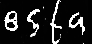

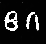

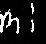

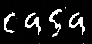

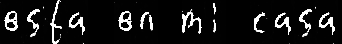

In [164]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import numpy as np

from matplotlib import cm

transform = T.ToPILImage()
images = []

sentence = 'esta en mi casa'.split(' ')


words_img = []
max_height = 44

for i in range(len(sentence)):
    word = sentence[i]
    x_offset = 0
    word_width = len(word)*23
    word_img = Image.new('RGB', (word_width, max_height))

    for letter in word:
        img, label = gan.generateImage(data_module.getLabelIndex(letter))
        img_numpy = img.detach().cpu()[0].permute(0,1,2)#[12:56,22:44]
        img_PIL = transform(img.detach().cpu()[0])
        img_PIL = img_PIL.crop((22,12,44,56))
        word_img.paste(img_PIL, (x_offset,0))
        x_offset += img_PIL.size[0]

    words_img.append(word_img)

    blank_img= transform(torch.zeros((64,64)))
    blank_img = blank_img.crop((22,12,44,56))

    word_img.show()
    if (i< len(sentence) -1): words_img.append(blank_img)



final_img = Image.new('RGB', (sum([img.size[0] for img in words_img]), max_height))

x_offset = 0
for word_img in words_img:
    final_img.paste(word_img, (x_offset,0))
    x_offset += word_img.size[0]

final_img.show()